In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

In [3]:
def sample(num):
    return np.array(np.random.uniform(-1,1,(num,2)), dtype='float32')

In [7]:
def sample_2(batch_size=500):
    x2_dist = tfd.Normal(loc=0., scale=4.)
    x2_samples = x2_dist.sample(batch_size)
    x1 = tfd.Normal(loc=.25 * tf.square(x2_samples),
                    scale=tf.ones(batch_size, dtype=tf.float32))
    x1_samples = x1.sample()
    x_samples = tf.stack([x1_samples, x2_samples], axis=1)
    return x_samples.numpy()/40.0

In [6]:
X = sample_2(1500)
X.shape

(1500, 2)

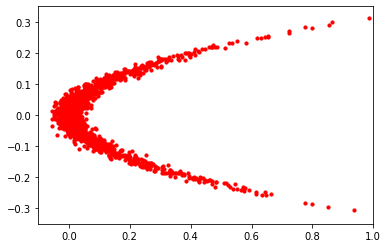

In [8]:
xlim, ylim = [-2, 2], [-2, 2]
plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
plt.xlim(-0.1,1)
plt.ylim(-0.35,0.35)
plt.show()

In [9]:
class RealNVP(tf.keras.models.Model):

    def __init__(self, *, output_dim, num_masked, **kwargs): #** additional arguments for the super class
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.nets=[]
        # We need to keep track of the nets
        bijectors=[] #A
        num_blocks = 5 #B
        h = 32  # C
        for i in range(num_blocks): 
            net = tfb.real_nvp_default_template([h, h])#D
            bijectors.append(
                tfb.RealNVP(shift_and_log_scale_fn=net, 
                            num_masked=num_masked))#E
            bijectors.append(tfb.Permute([1,0])) #F
            self.nets.append(net) 
        bijector = tfb.Chain(list(reversed(bijectors[:-1])))

        self.flow = tfd.TransformedDistribution(#G
            distribution=tfd.MultivariateNormalDiag(loc=[0., 0.]), 
            bijector=bijector)
        
#A List of bijectors, to this list we add num_blocks of coupling permutations blocks   
#B Number of hidden layers in the NF model
#C size of the hidden layers 
#D Definition of the Network
#E A shift and flow with parameters from the network
#F Permutation of coordinates
#G Distribution using z with two independent Gaussians

    def call(self, *inputs): 
        return self.flow.bijector.forward(*inputs)
    

model = RealNVP(output_dim=2, num_masked=1)
### Below is a bit magic stuff, concerning eager execution
#model.summary() #Yields an error. The model needs called before it is build.
_ = model(X) 
print(model.summary())


#A List of bijectors
#B Stacking of 5 layers
#C Definition of the Network
#D A shift and flow with parameters from the network
#E Permutation of coordinates
#F Distribution using z with two independent Gaussians

Model: "real_nvp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 5,930
Trainable params: 5,930
Non-trainable params: 0
_________________________________________________________________
None


/home/jihoon/.pyenv/versions/3.8.7/envs/PDL/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/jihoon/.pyenv/versions/3.8.7/envs/PDL/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
##### Important
#Needs to be called other-wise @tf.function has problem
-tf.reduce_mean(model.flow.log_prob(X)) 

@tf.function #Adding the tf.function makes it about 10-50 times faster!!!
def train_step(X): 
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(model.flow.log_prob(X)) 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss      

from time import time
start = time()
for i in range(1001):
    #Xs = sample(1000) #Creat new training data
    loss = train_step(X)
    if (i % 100 == 0):
        print(i, " ",loss.numpy(), (time()-start))
        start = time()

/home/jihoon/.pyenv/versions/3.8.7/envs/PDL/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


0   1.8053107 1.8791263103485107
100   -2.1250863 0.744877815246582
200   -3.079801 0.6079416275024414
300   -3.1359518 0.5968277454376221
400   -3.152421 0.602900505065918
500   -3.1615562 0.6058406829833984
600   -3.1644838 0.6228477954864502
700   -3.1671934 0.6382665634155273
800   -3.1690261 0.6445455551147461
900   -3.1702468 0.7056407928466797
1000   -3.1711173 0.6558547019958496


(-0.35, 0.35)

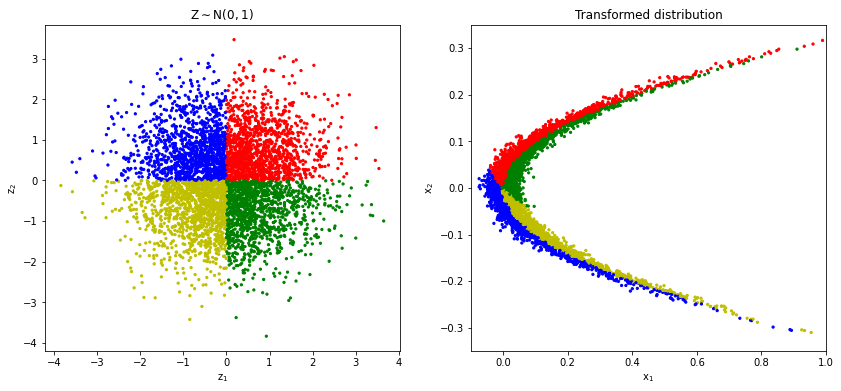

In [12]:
#XF = model.flow.sample(5000)
Z = np.random.normal(0,1,(5000,2))
cols = []
for i in range(5000):
    if (Z[i,0] > 0 and Z[i,1] > 0):
        cols.append('r')
    elif (Z[i,0] < 0 and Z[i,1] > 0):
        cols.append('b')
    elif (Z[i,0] < 0 and Z[i,1] < 0):
        cols.append('y')
    else:
        cols.append('g')

plt.figure(figsize=(14,6))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

plt.subplot(1,2,1)
plt.scatter(Z[:, 0], Z[:, 1], s=5,c=cols)
plt.title('$Z \sim N(0,1)$')
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')

Xs = model(Z)

plt.subplot(1,2,2)
plt.title('Transformed distribution')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.scatter(Xs[:,0], Xs[:, 1], s=5, c=cols)
plt.xlim(-0.1,1)
plt.ylim(-0.35,0.35)

In [15]:
plt.style.use('default')
plt.rcParams.update({'font.size': 15}) 


X1 = np.array((0.6,0.25), dtype=np.float32)    #Starting point corresponing to Beyonce
X2 = np.array((0.6,-0.25), dtype=np.float32)   #End point corresponing to DiCaprio

Z1 = model.flow.bijector.inverse(X1)        # Same 
Z2 = model.flow.bijector.inverse(X2)

# Z1 = np.array((-1.5,-1.5), dtype=float32) 
# Z2= np.array((1.5,1.5), dtype=float32) 

nums = 500
Z_mixs = np.zeros((nums,2),dtype=np.float32)
for i,m in enumerate(np.linspace(0,1,nums)):
    Z_mixs[i] = (Z2*m+Z1*(1.-m))
  

/home/jihoon/.pyenv/versions/3.8.7/envs/PDL/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/jihoon/.pyenv/versions/3.8.7/envs/PDL/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [19]:
Z_mixs[:10]

array([[2.0898812, 1.9265376],
       [2.0802634, 1.9243125],
       [2.0706456, 1.9220873],
       [2.0610275, 1.9198622],
       [2.0514097, 1.917637 ],
       [2.041792 , 1.9154118],
       [2.0321736, 1.9131867],
       [2.0225558, 1.9109615],
       [2.012938 , 1.9087363],
       [2.00332  , 1.9065112]], dtype=float32)

/home/jihoon/.pyenv/versions/3.8.7/envs/PDL/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/jihoon/.pyenv/versions/3.8.7/envs/PDL/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


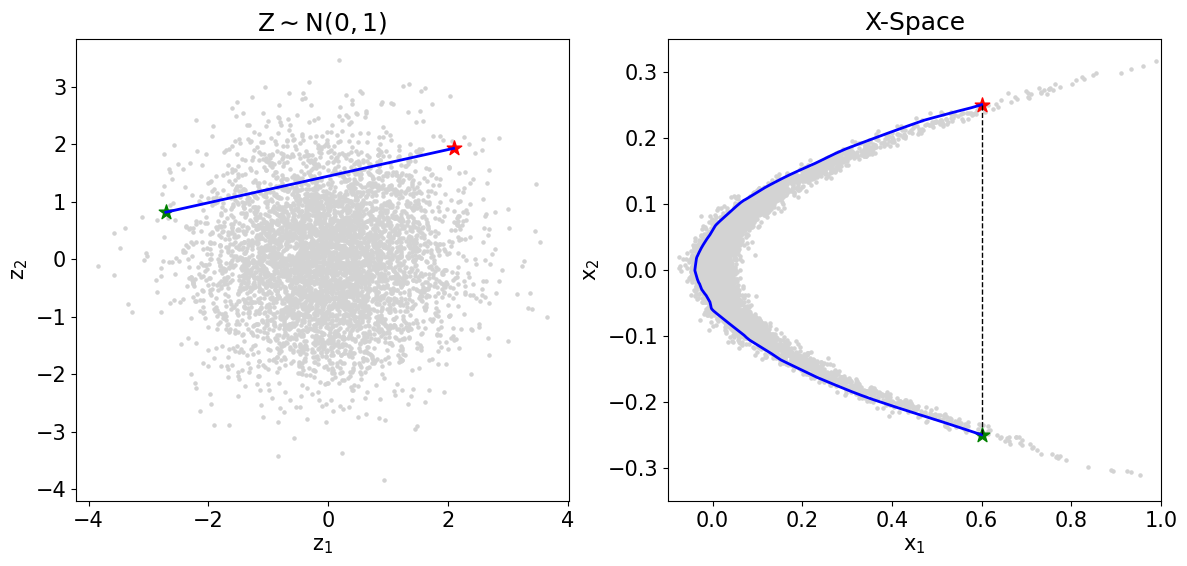

In [20]:
plt.figure(figsize=(14,6))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

plt.subplot(1,2,1)
plt.scatter(Z[:, 0], Z[:, 1], s=5,c='lightgray')
plt.plot(Z_mixs[:,0],Z_mixs[:,1],c='blue', linewidth=2)
plt.scatter(Z_mixs[0,0],Z_mixs[0,1],c='red', s=120,marker='*')
plt.scatter(Z_mixs[nums-1,0],Z_mixs[nums-1,1],c='green', s=120,marker='*')

plt.title('$Z \sim N(0,1)$')
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')

plt.subplot(1,2,2)
plt.title('X-Space')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.scatter(Xs[:,0], Xs[:, 1], s=5,c='lightgray')
plt.xlim(-0.1,1)
plt.ylim(-0.35,0.35)
plt.scatter(X1[0], X1[1], s=10)
plt.scatter(X2[0], X2[1], s=10)

X_mix = model.flow.bijector.forward(Z_mixs)

plt.plot(X_mix[:,0],X_mix[:,1],c='blue',linewidth=2)
plt.scatter(X1[0],X1[1],c='red', s=120,marker='*')
plt.scatter(X2[0],X2[1],c='green', s=120,marker='*')

X_mixs = np.zeros((nums,2),dtype=np.float32)
for i,m in enumerate(np.linspace(0,1,nums)):
    X_mixs[i] = (X2*m+X1*(1.-m))
plt.plot(X_mixs[:,0],X_mixs[:,1],'--',c='black', linewidth=1.)

In [21]:
class Mask_AR(tf.keras.models.Model):

    def __init__(self, *, output_dim, num_masked, **kwargs): #** additional arguments for the super class
        super().__init__(**kwargs)
        self.output_dim = output_dim
        # We need to keep track of the nets
        self.nets = []
        
        # Defining the bijector
        bijectors=[] 
      
        h = 32
        for i in range(3): 
            
            ##### Here is some difference to RealNVP
            net = tfb.masked_autoregressive_default_template(hidden_layers=[h, h])
            # masked_autoregressive_default_template constructs a special network, 
            # which preserves the autoregressive property, called MADE.
            
            bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=net))
            #bijectors.append(tfb.Invert(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=net)))
            #Uncommentung the line above (and commenting two lines above), would create a so-called inverse
            #autoregressive flow which is faster in prediction, but slower in training
            
            ##### End of difference
            
            bijectors.append(tfb.Permute([1,0])) 
            self.nets.append(net) 
        bijector = tfb.Chain(list(reversed(bijectors[:-1])))
        
        self.flow = tfd.TransformedDistribution(
            distribution=tfd.MultivariateNormalDiag(loc=[0., 0.]), 
            bijector=bijector)

    def call(self, *inputs): 
        return self.flow.bijector.forward(*inputs)


model = Mask_AR(output_dim=2, num_masked=1)
_ = model(X) 
print(model.summary())

Instructions for updating:
`masked_autoregressive_default_template` is deprecated; use `tfp.bijectors.AutoregressiveNetwork`.   Also, please note the section "Variable Tracking" in the documentation for `tfp.bijectors.MaskedAutoregressiveFlow`.
Model: "mask_ar"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 3,852
Trainable params: 3,852
Non-trainable params: 0
_________________________________________________________________
None


/home/jihoon/.pyenv/versions/3.8.7/envs/PDL/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
##### Important
#Needs to be called other-wise @tf.function has problem
-tf.reduce_mean(model.flow.log_prob(X)) 

@tf.function #Adding the tf.function makes it about 10-50 times faster!!!
def train_step(X): 
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(model.flow.log_prob(X)) 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss      

from time import time
start = time()
for i in range(1001):
    #Xs = sample(1000) #Creat new training data
    loss = train_step(X)
    if (i % 100 == 0):
        print(i, " ",loss.numpy(), (time()-start))
        start = time()

/home/jihoon/.pyenv/versions/3.8.7/envs/PDL/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


0   1.8673545 1.1483299732208252
100   -0.36233324 0.4898393154144287
200   -2.5229535 0.40140652656555176
300   -3.0876334 0.3870375156402588
400   -3.1269436 0.36968493461608887
500   -3.140657 0.36621737480163574
600   -3.1463099 0.35592174530029297
700   -3.1483638 0.3581812381744385
800   -3.1498759 0.3786025047302246
900   -3.1506417 0.3630368709564209
1000   -3.150315 0.3760504722595215


(-0.35, 0.35)

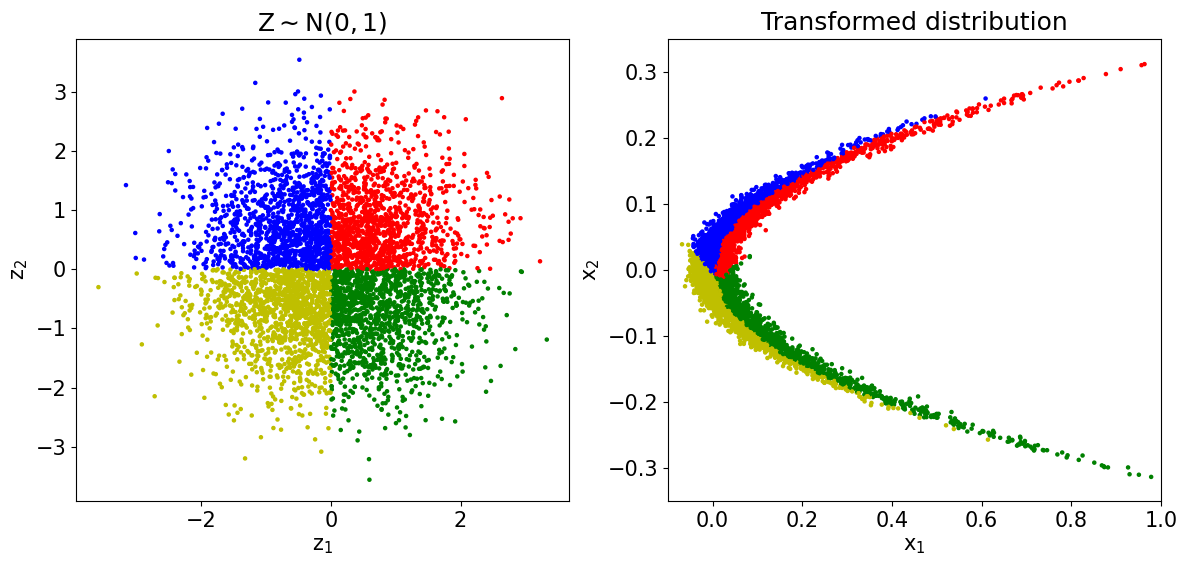

In [24]:
#XF = model.flow.sample(5000)
Z = np.random.normal(0,1,(5000,2))
cols = []
for i in range(5000):
    if (Z[i,0] > 0 and Z[i,1] > 0):
        cols.append('r')
    elif (Z[i,0] < 0 and Z[i,1] > 0):
        cols.append('b')
    elif (Z[i,0] < 0 and Z[i,1] < 0):
        cols.append('y')
    else:
        cols.append('g')

plt.figure(figsize=(14,6))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

plt.subplot(1,2,1)
plt.scatter(Z[:, 0], Z[:, 1], s=5,c=cols)
plt.title('$Z \sim N(0,1)$')
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
Xs = model(Z)

plt.subplot(1,2,2)
plt.title('Transformed distribution')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.scatter(Xs[:,0], Xs[:, 1], s=5, c=cols)
plt.xlim(-0.1,1)
plt.ylim(-0.35,0.35)
